In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import plot_confusion_matrix

# XGBoost

In [2]:
import xgboost as xgb
import optuna

In [16]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']
clf = {}
scores = {}

for region in regions:
    # read data
    df = pd.read_csv(f'../data/safe/{region}.csv')
    
    # split train / valid / test
    X, y = df.drop(['Date', 'Safe'], axis = 1), df['Safe']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

    # hyperparams tuning
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    # define objective function
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 600),
            'max_depth': trial.suggest_int('max_depth', 10, 20),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, .1),
            'subsample': trial.suggest_uniform('subsample', 0.50, 1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
            'gamma': trial.suggest_int('gamma', 0, 10),
            'objective': 'binary:logistic'
        }

        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        pred_labels = np.rint(preds)

        recall = recall_score(y_valid, pred_labels)
        return recall
                                                        
    # optuna optimize
    study = optuna.create_study(direction = "maximize")
    study.optimize(objective, n_trials=10)
    
    print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))
    
    # classifier
    best_params = study.best_trial.params
    best_params['objective'] = 'binary:logistic'
    clf[region] = xgb.XGBClassifier(**best_params)
    
    clf[region].fit(X_train, y_train)
    
    # predict
    score = {}
    
    y_pred = clf[region].predict(X_train)
    score['train_recall'] = recall_score(y_train, y_pred)
    y_pred = clf[region].predict(X_valid)
    score['valid_recall'] = recall_score(y_valid, y_pred)
    y_pred = clf[region].predict(X_test)
    score['test_recall'] = recall_score(y_test, y_pred)
    
    y_pred = clf[region].predict(X_train)
    score['train_precision'] = precision_score(y_train, y_pred)
    y_pred = clf[region].predict(X_valid)
    score['valid_precision'] = precision_score(y_valid, y_pred)
    y_pred = clf[region].predict(X_test)
    score['test_precision'] = precision_score(y_test, y_pred)
    
    y_pred = clf[region].predict(X_train)
    score['train_f1_score'] = f1_score(y_train, y_pred)
    y_pred = clf[region].predict(X_valid)
    score['valid_f1_score'] = f1_score(y_valid, y_pred)
    y_pred = clf[region].predict(X_test)
    score['test_f1_score'] = f1_score(y_test, y_pred)
    
    scores[region] = score

[I 2021-01-13 21:08:03,136] A new study created in memory with name: no-name-f0bfc715-d03c-4da3-94f8-9db1b07c759c


[21:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:03,426] Trial 0 finished with value: 0.37280701754385964 and parameters: {'n_estimators': 431, 'max_depth': 14, 'learning_rate': 0.07396853758833676, 'subsample': 0.8882194999869335, 'colsample_bytree': 0.6081415092074662, 'gamma': 4}. Best is trial 0 with value: 0.37280701754385964.
[I 2021-01-13 21:08:03,539] Trial 1 finished with value: 0.38596491228070173 and parameters: {'n_estimators': 477, 'max_depth': 20, 'learning_rate': 0.0911195487924574, 'subsample': 0.5582769378494025, 'colsample_bytree': 0.5110991641553585, 'gamma': 8}. Best is trial 1 with value: 0.38596491228070173.


[21:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:03,719] Trial 2 finished with value: 0.37280701754385964 and parameters: {'n_estimators': 569, 'max_depth': 10, 'learning_rate': 0.099270690251822, 'subsample': 0.8742705383434111, 'colsample_bytree': 0.7988750028419717, 'gamma': 10}. Best is trial 1 with value: 0.38596491228070173.
[I 2021-01-13 21:08:03,881] Trial 3 finished with value: 0.39473684210526316 and parameters: {'n_estimators': 559, 'max_depth': 16, 'learning_rate': 0.03630595561816123, 'subsample': 0.6802951182944034, 'colsample_bytree': 0.560378158282476, 'gamma': 2}. Best is trial 3 with value: 0.39473684210526316.


[21:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:04,045] Trial 4 finished with value: 0.36403508771929827 and parameters: {'n_estimators': 415, 'max_depth': 19, 'learning_rate': 0.048974543829741715, 'subsample': 0.7523123982902327, 'colsample_bytree': 0.5614409495400442, 'gamma': 9}. Best is trial 3 with value: 0.39473684210526316.
[I 2021-01-13 21:08:04,174] Trial 5 finished with value: 0.40350877192982454 and parameters: {'n_estimators': 408, 'max_depth': 10, 'learning_rate': 0.09850107668067987, 'subsample': 0.6614969338141943, 'colsample_bytree': 0.6378947980233743, 'gamma': 1}. Best is trial 5 with value: 0.40350877192982454.


[21:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:04,495] Trial 6 finished with value: 0.3991228070175439 and parameters: {'n_estimators': 454, 'max_depth': 13, 'learning_rate': 0.09741341801718426, 'subsample': 0.665847427667762, 'colsample_bytree': 0.9746172786053506, 'gamma': 8}. Best is trial 5 with value: 0.40350877192982454.


[21:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:04,785] Trial 7 finished with value: 0.42105263157894735 and parameters: {'n_estimators': 520, 'max_depth': 15, 'learning_rate': 0.015275594739984907, 'subsample': 0.9953144976753044, 'colsample_bytree': 0.7560514695665159, 'gamma': 2}. Best is trial 7 with value: 0.42105263157894735.
[I 2021-01-13 21:08:04,942] Trial 8 finished with value: 0.35964912280701755 and parameters: {'n_estimators': 488, 'max_depth': 17, 'learning_rate': 0.04524068213467413, 'subsample': 0.7897338545562382, 'colsample_bytree': 0.7921337121949996, 'gamma': 9}. Best is trial 7 with value: 0.42105263157894735.


[21:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:05,101] Trial 9 finished with value: 0.3991228070175439 and parameters: {'n_estimators': 507, 'max_depth': 13, 'learning_rate': 0.039930887956086576, 'subsample': 0.656643123524107, 'colsample_bytree': 0.7871703714218191, 'gamma': 5}. Best is trial 7 with value: 0.42105263157894735.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best trial: score 0.42105263157894735, params {'n_estimators': 520, 'max_depth': 15, 'learning_rate': 0.015275594739984907, 'subsample': 0.9953144976753044, 'colsample_bytree': 0.7560514695665159, 'gamma': 2}
[21:08:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:16,173] A new study created in memory with name: no-name-af44e30a-a7db-4b4f-b664-77da5ab6ea1a
[I 2021-01-13 21:08:16,316] Trial 0 finished with value: 0.5255474452554745 and parameters: {'n_estimators': 571, 'max_depth': 16, 'learning_rate': 0.021638195700550998, 'subsample': 0.9882310026197005, 'colsample_bytree': 0.5642675444144134, 'gamma': 4}. Best is trial 0 with value: 0.5255474452554745.


[21:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:16,466] Trial 1 finished with value: 0.5474452554744526 and parameters: {'n_estimators': 506, 'max_depth': 20, 'learning_rate': 0.08135182836995086, 'subsample': 0.840799476068178, 'colsample_bytree': 0.6547582559299747, 'gamma': 8}. Best is trial 1 with value: 0.5474452554744526.
[I 2021-01-13 21:08:16,592] Trial 2 finished with value: 0.5255474452554745 and parameters: {'n_estimators': 485, 'max_depth': 18, 'learning_rate': 0.09955706188744722, 'subsample': 0.7386492659075174, 'colsample_bytree': 0.7858953245990655, 'gamma': 1}. Best is trial 1 with value: 0.5474452554744526.


[21:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:16,720] Trial 3 finished with value: 0.5182481751824818 and parameters: {'n_estimators': 439, 'max_depth': 20, 'learning_rate': 0.09179620359597668, 'subsample': 0.8269391069116523, 'colsample_bytree': 0.6015341342282131, 'gamma': 0}. Best is trial 1 with value: 0.5474452554744526.
[I 2021-01-13 21:08:16,835] Trial 4 finished with value: 0.5401459854014599 and parameters: {'n_estimators': 557, 'max_depth': 16, 'learning_rate': 0.09649631610040289, 'subsample': 0.5765087711466946, 'colsample_bytree': 0.785957286160304, 'gamma': 8}. Best is trial 1 with value: 0.5474452554744526.


[21:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:17,013] Trial 5 finished with value: 0.5328467153284672 and parameters: {'n_estimators': 469, 'max_depth': 16, 'learning_rate': 0.06504891375715134, 'subsample': 0.8632601632282357, 'colsample_bytree': 0.9540302958061948, 'gamma': 9}. Best is trial 1 with value: 0.5474452554744526.
[I 2021-01-13 21:08:17,136] Trial 6 finished with value: 0.5766423357664233 and parameters: {'n_estimators': 462, 'max_depth': 16, 'learning_rate': 0.09490033930943204, 'subsample': 0.6101502707495456, 'colsample_bytree': 0.9692441618679908, 'gamma': 8}. Best is trial 6 with value: 0.5766423357664233.


[21:08:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:17,263] Trial 7 finished with value: 0.5255474452554745 and parameters: {'n_estimators': 503, 'max_depth': 12, 'learning_rate': 0.045961846121422456, 'subsample': 0.7442795069506822, 'colsample_bytree': 0.6513199614204556, 'gamma': 2}. Best is trial 6 with value: 0.5766423357664233.
[I 2021-01-13 21:08:17,392] Trial 8 finished with value: 0.5328467153284672 and parameters: {'n_estimators': 576, 'max_depth': 18, 'learning_rate': 0.05137268262468313, 'subsample': 0.8239839983108515, 'colsample_bytree': 0.7028483726128413, 'gamma': 1}. Best is trial 6 with value: 0.5766423357664233.


[21:08:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:17,594] Trial 9 finished with value: 0.5401459854014599 and parameters: {'n_estimators': 492, 'max_depth': 19, 'learning_rate': 0.029154403887440797, 'subsample': 0.892718727859549, 'colsample_bytree': 0.944535359925804, 'gamma': 2}. Best is trial 6 with value: 0.5766423357664233.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best trial: score 0.5766423357664233, params {'n_estimators': 462, 'max_depth': 16, 'learning_rate': 0.09490033930943204, 'subsample': 0.6101502707495456, 'colsample_bytree': 0.9692441618679908, 'gamma': 8}
[21:08:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:24,329] A new study created in memory with name: no-name-58f2f056-c340-4c1c-84a5-8c05b44e1391


[21:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:24,587] Trial 0 finished with value: 0.2549019607843137 and parameters: {'n_estimators': 493, 'max_depth': 14, 'learning_rate': 0.07998900829215283, 'subsample': 0.9634482676396554, 'colsample_bytree': 0.6378259826375803, 'gamma': 1}. Best is trial 0 with value: 0.2549019607843137.
[I 2021-01-13 21:08:24,736] Trial 1 finished with value: 0.17647058823529413 and parameters: {'n_estimators': 464, 'max_depth': 18, 'learning_rate': 0.0397775034427329, 'subsample': 0.5093560395709076, 'colsample_bytree': 0.7458168819932398, 'gamma': 9}. Best is trial 0 with value: 0.2549019607843137.


[21:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:24,841] Trial 2 finished with value: 0.0784313725490196 and parameters: {'n_estimators': 408, 'max_depth': 15, 'learning_rate': 0.055186749194123925, 'subsample': 0.5883244958901824, 'colsample_bytree': 0.6725726380257925, 'gamma': 9}. Best is trial 0 with value: 0.2549019607843137.


[21:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:25,089] Trial 3 finished with value: 0.2549019607843137 and parameters: {'n_estimators': 483, 'max_depth': 12, 'learning_rate': 0.014908333472570976, 'subsample': 0.7532584251470651, 'colsample_bytree': 0.8266367072176943, 'gamma': 1}. Best is trial 0 with value: 0.2549019607843137.
[I 2021-01-13 21:08:25,267] Trial 4 finished with value: 0.19607843137254902 and parameters: {'n_estimators': 501, 'max_depth': 19, 'learning_rate': 0.09187827316317757, 'subsample': 0.5485643035963554, 'colsample_bytree': 0.6556908059249322, 'gamma': 3}. Best is trial 0 with value: 0.2549019607843137.


[21:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:25,402] Trial 5 finished with value: 0.11764705882352941 and parameters: {'n_estimators': 438, 'max_depth': 11, 'learning_rate': 0.022126033005096073, 'subsample': 0.81588125119347, 'colsample_bytree': 0.691070302077347, 'gamma': 5}. Best is trial 0 with value: 0.2549019607843137.
[I 2021-01-13 21:08:25,523] Trial 6 finished with value: 0.09803921568627451 and parameters: {'n_estimators': 451, 'max_depth': 14, 'learning_rate': 0.052077908957459444, 'subsample': 0.8527604377273083, 'colsample_bytree': 0.5114924570678168, 'gamma': 5}. Best is trial 0 with value: 0.2549019607843137.


[21:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:25,678] Trial 7 finished with value: 0.13725490196078433 and parameters: {'n_estimators': 546, 'max_depth': 18, 'learning_rate': 0.049324263227503704, 'subsample': 0.6650025963681464, 'colsample_bytree': 0.9224019963775065, 'gamma': 8}. Best is trial 0 with value: 0.2549019607843137.
[I 2021-01-13 21:08:25,821] Trial 8 finished with value: 0.2549019607843137 and parameters: {'n_estimators': 482, 'max_depth': 14, 'learning_rate': 0.09041926367185575, 'subsample': 0.9049862315496662, 'colsample_bytree': 0.8828085558783227, 'gamma': 3}. Best is trial 0 with value: 0.2549019607843137.


[21:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:25,933] Trial 9 finished with value: 0.17647058823529413 and parameters: {'n_estimators': 556, 'max_depth': 10, 'learning_rate': 0.03626569920515318, 'subsample': 0.5953887382774015, 'colsample_bytree': 0.6373155751259749, 'gamma': 2}. Best is trial 0 with value: 0.2549019607843137.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best trial: score 0.2549019607843137, params {'n_estimators': 493, 'max_depth': 14, 'learning_rate': 0.07998900829215283, 'subsample': 0.9634482676396554, 'colsample_bytree': 0.6378259826375803, 'gamma': 1}
[21:08:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:33,946] A new study created in memory with name: no-name-43664866-ae91-4f8e-995e-3562375b2823


[21:08:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:34,257] Trial 0 finished with value: 0.8843626806833115 and parameters: {'n_estimators': 427, 'max_depth': 16, 'learning_rate': 0.02548825162884743, 'subsample': 0.5261954605643264, 'colsample_bytree': 0.7824593992948534, 'gamma': 7}. Best is trial 0 with value: 0.8843626806833115.


[21:08:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:34,555] Trial 1 finished with value: 0.8804204993429697 and parameters: {'n_estimators': 450, 'max_depth': 14, 'learning_rate': 0.0324447577105914, 'subsample': 0.7936285192306395, 'colsample_bytree': 0.7282879405607343, 'gamma': 9}. Best is trial 0 with value: 0.8843626806833115.


[21:08:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:34,982] Trial 2 finished with value: 0.8488830486202366 and parameters: {'n_estimators': 435, 'max_depth': 20, 'learning_rate': 0.0903176327328476, 'subsample': 0.5556917907826919, 'colsample_bytree': 0.7096659553510503, 'gamma': 4}. Best is trial 0 with value: 0.8843626806833115.


[21:08:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:35,232] Trial 3 finished with value: 0.8869908015768725 and parameters: {'n_estimators': 531, 'max_depth': 10, 'learning_rate': 0.0584112251786558, 'subsample': 0.7264341781351586, 'colsample_bytree': 0.5764274359060351, 'gamma': 7}. Best is trial 3 with value: 0.8869908015768725.


[21:08:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:35,556] Trial 4 finished with value: 0.8396846254927727 and parameters: {'n_estimators': 528, 'max_depth': 18, 'learning_rate': 0.04628112479035671, 'subsample': 0.940950106766232, 'colsample_bytree': 0.923757954049212, 'gamma': 1}. Best is trial 3 with value: 0.8869908015768725.


[21:08:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:35,852] Trial 5 finished with value: 0.8515111695137977 and parameters: {'n_estimators': 533, 'max_depth': 16, 'learning_rate': 0.07381485683022826, 'subsample': 0.8812960519779625, 'colsample_bytree': 0.714192717036571, 'gamma': 3}. Best is trial 3 with value: 0.8869908015768725.


[21:08:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:36,144] Trial 6 finished with value: 0.8699080157687253 and parameters: {'n_estimators': 539, 'max_depth': 10, 'learning_rate': 0.0812847124075093, 'subsample': 0.7133796390454232, 'colsample_bytree': 0.5887555608864415, 'gamma': 6}. Best is trial 3 with value: 0.8869908015768725.


[21:08:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:36,384] Trial 7 finished with value: 0.8672798948751642 and parameters: {'n_estimators': 599, 'max_depth': 13, 'learning_rate': 0.043186337935792046, 'subsample': 0.8932905003099102, 'colsample_bytree': 0.5464763091266662, 'gamma': 3}. Best is trial 3 with value: 0.8869908015768725.


[21:08:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:36,663] Trial 8 finished with value: 0.8580814717477004 and parameters: {'n_estimators': 458, 'max_depth': 20, 'learning_rate': 0.09871908881418266, 'subsample': 0.6481827605341896, 'colsample_bytree': 0.9842102119936176, 'gamma': 6}. Best is trial 3 with value: 0.8869908015768725.
[I 2021-01-13 21:08:36,853] Trial 9 finished with value: 0.8252299605781866 and parameters: {'n_estimators': 592, 'max_depth': 18, 'learning_rate': 0.033002847478472284, 'subsample': 0.7314859940717517, 'colsample_bytree': 0.7091855185253813, 'gamma': 0}. Best is trial 3 with value: 0.8869908015768725.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i

[21:08:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best trial: score 0.8869908015768725, params {'n_estimators': 531, 'max_depth': 10, 'learning_rate': 0.0584112251786558, 'subsample': 0.7264341781351586, 'colsample_bytree': 0.5764274359060351, 'gamma': 7}
[21:08:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objec

[I 2021-01-13 21:08:43,909] A new study created in memory with name: no-name-d3529817-725e-420b-8fd9-4cff5931c170
[I 2021-01-13 21:08:44,077] Trial 0 finished with value: 0.9446366782006921 and parameters: {'n_estimators': 555, 'max_depth': 15, 'learning_rate': 0.057198035043878145, 'subsample': 0.5600196248765965, 'colsample_bytree': 0.6875529441884096, 'gamma': 10}. Best is trial 0 with value: 0.9446366782006921.


[21:08:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:44,339] Trial 1 finished with value: 0.9423298731257209 and parameters: {'n_estimators': 583, 'max_depth': 12, 'learning_rate': 0.0865683866184182, 'subsample': 0.9619666294937295, 'colsample_bytree': 0.5427578513582413, 'gamma': 8}. Best is trial 0 with value: 0.9446366782006921.


[21:08:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:44,634] Trial 2 finished with value: 0.9261822376009228 and parameters: {'n_estimators': 563, 'max_depth': 16, 'learning_rate': 0.048548399440848045, 'subsample': 0.9025062265444728, 'colsample_bytree': 0.8405983742056863, 'gamma': 4}. Best is trial 0 with value: 0.9446366782006921.


[21:08:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:44,925] Trial 3 finished with value: 0.9342560553633218 and parameters: {'n_estimators': 593, 'max_depth': 12, 'learning_rate': 0.02357145873862864, 'subsample': 0.5548228248666007, 'colsample_bytree': 0.9597155887774678, 'gamma': 7}. Best is trial 0 with value: 0.9446366782006921.
[I 2021-01-13 21:08:45,118] Trial 4 finished with value: 0.9192618223760092 and parameters: {'n_estimators': 600, 'max_depth': 12, 'learning_rate': 0.0554716688879549, 'subsample': 0.9426721857453089, 'colsample_bytree': 0.7306011339240281, 'gamma': 2}. Best is trial 0 with value: 0.9446366782006921.


[21:08:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:45,328] Trial 5 finished with value: 0.9181084198385236 and parameters: {'n_estimators': 498, 'max_depth': 19, 'learning_rate': 0.026086620847661272, 'subsample': 0.7913473950275195, 'colsample_bytree': 0.745059902541164, 'gamma': 1}. Best is trial 0 with value: 0.9446366782006921.


[21:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:45,548] Trial 6 finished with value: 0.9342560553633218 and parameters: {'n_estimators': 574, 'max_depth': 13, 'learning_rate': 0.011677566890574368, 'subsample': 0.9158659598974779, 'colsample_bytree': 0.7729031478259063, 'gamma': 10}. Best is trial 0 with value: 0.9446366782006921.
[I 2021-01-13 21:08:45,711] Trial 7 finished with value: 0.9238754325259516 and parameters: {'n_estimators': 571, 'max_depth': 19, 'learning_rate': 0.09948081273865723, 'subsample': 0.6802768652997055, 'colsample_bytree': 0.6103588564885483, 'gamma': 1}. Best is trial 0 with value: 0.9446366782006921.


[21:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:45,863] Trial 8 finished with value: 0.9538638985005767 and parameters: {'n_estimators': 552, 'max_depth': 17, 'learning_rate': 0.03916200731815953, 'subsample': 0.5254613936785231, 'colsample_bytree': 0.5592882213495385, 'gamma': 10}. Best is trial 8 with value: 0.9538638985005767.


[21:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:46,090] Trial 9 finished with value: 0.9354094579008074 and parameters: {'n_estimators': 478, 'max_depth': 20, 'learning_rate': 0.09500576272010046, 'subsample': 0.9017862193688564, 'colsample_bytree': 0.6556718968596457, 'gamma': 10}. Best is trial 8 with value: 0.9538638985005767.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best trial: score 0.9538638985005767, params {'n_estimators': 552, 'max_depth': 17, 'learning_rate': 0.03916200731815953, 'subsample': 0.5254613936785231, 'colsample_bytree': 0.5592882213495385, 'gamma': 10}
[21:08:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:54,330] A new study created in memory with name: no-name-1255e3e0-b507-4cc7-8574-0697663e2d8c


[21:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:54,554] Trial 0 finished with value: 0.859697386519945 and parameters: {'n_estimators': 552, 'max_depth': 15, 'learning_rate': 0.047786173556995035, 'subsample': 0.8451384743960175, 'colsample_bytree': 0.5714696865260672, 'gamma': 1}. Best is trial 0 with value: 0.859697386519945.
[I 2021-01-13 21:08:54,752] Trial 1 finished with value: 0.8583218707015131 and parameters: {'n_estimators': 475, 'max_depth': 18, 'learning_rate': 0.028305656610667973, 'subsample': 0.632803645377288, 'colsample_bytree': 0.6993216521625549, 'gamma': 2}. Best is trial 0 with value: 0.859697386519945.


[21:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:54,925] Trial 2 finished with value: 0.8789546079779917 and parameters: {'n_estimators': 406, 'max_depth': 16, 'learning_rate': 0.09016303815132314, 'subsample': 0.5935629180572204, 'colsample_bytree': 0.6120645590884382, 'gamma': 10}. Best is trial 2 with value: 0.8789546079779917.


[21:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:55,229] Trial 3 finished with value: 0.8514442916093535 and parameters: {'n_estimators': 416, 'max_depth': 11, 'learning_rate': 0.01679273809041376, 'subsample': 0.932724147518621, 'colsample_bytree': 0.8886282059648645, 'gamma': 4}. Best is trial 2 with value: 0.8789546079779917.


[21:08:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:55,466] Trial 4 finished with value: 0.8665749656121046 and parameters: {'n_estimators': 524, 'max_depth': 12, 'learning_rate': 0.017839282485625958, 'subsample': 0.5068698436566155, 'colsample_bytree': 0.982777919476767, 'gamma': 7}. Best is trial 2 with value: 0.8789546079779917.


[21:08:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:55,847] Trial 5 finished with value: 0.8418156808803301 and parameters: {'n_estimators': 501, 'max_depth': 12, 'learning_rate': 0.06030233233877524, 'subsample': 0.5979174766185165, 'colsample_bytree': 0.5502539959718675, 'gamma': 1}. Best is trial 2 with value: 0.8789546079779917.


[21:08:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:56,088] Trial 6 finished with value: 0.8789546079779917 and parameters: {'n_estimators': 424, 'max_depth': 18, 'learning_rate': 0.08755408623586872, 'subsample': 0.7303640674430787, 'colsample_bytree': 0.7754859342521113, 'gamma': 9}. Best is trial 2 with value: 0.8789546079779917.
[I 2021-01-13 21:08:56,238] Trial 7 finished with value: 0.8404401650618982 and parameters: {'n_estimators': 418, 'max_depth': 12, 'learning_rate': 0.027958213531831318, 'subsample': 0.5659818557661855, 'colsample_bytree': 0.6010971787492286, 'gamma': 0}. Best is trial 2 with value: 0.8789546079779917.


[21:08:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:08:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:08:56,413] Trial 8 finished with value: 0.8473177441540578 and parameters: {'n_estimators': 590, 'max_depth': 16, 'learning_rate': 0.07362158737048596, 'subsample': 0.533698794236262, 'colsample_bytree': 0.5925992493714418, 'gamma': 6}. Best is trial 2 with value: 0.8789546079779917.


[21:08:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:08:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:08:56,697] Trial 9 finished with value: 0.8541953232462174 and parameters: {'n_estimators': 566, 'max_depth': 16, 'learning_rate': 0.0218538407893708, 'subsample': 0.8959113599306652, 'colsample_bytree': 0.7963745962809148, 'gamma': 8}. Best is trial 2 with value: 0.8789546079779917.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best trial: score 0.8789546079779917, params {'n_estimators': 406, 'max_depth': 16, 'learning_rate': 0.09016303815132314, 'subsample': 0.5935629180572204, 'colsample_bytree': 0.6120645590884382, 'gamma': 10}
[21:08:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:09:03,250] A new study created in memory with name: no-name-5345800f-5ae8-4175-950b-6e38694c6f10
[I 2021-01-13 21:09:03,448] Trial 0 finished with value: 0.030303030303030304 and parameters: {'n_estimators': 583, 'max_depth': 14, 'learning_rate': 0.018569991143678313, 'subsample': 0.8014178040589504, 'colsample_bytree': 0.749944479946712, 'gamma': 7}. Best is trial 0 with value: 0.030303030303030304.


[21:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:09:03,596] Trial 1 finished with value: 0.030303030303030304 and parameters: {'n_estimators': 530, 'max_depth': 20, 'learning_rate': 0.08111702134032382, 'subsample': 0.530251064616609, 'colsample_bytree': 0.8841508062659131, 'gamma': 9}. Best is trial 0 with value: 0.030303030303030304.


[21:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:09:03,805] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 456, 'max_depth': 19, 'learning_rate': 0.0765268615709426, 'subsample': 0.5323287750405885, 'colsample_bytree': 0.786304544356456, 'gamma': 10}. Best is trial 0 with value: 0.030303030303030304.
[I 2021-01-13 21:09:03,992] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 545, 'max_depth': 15, 'learning_rate': 0.02491689375621871, 'subsample': 0.6216227855559181, 'colsample_bytree': 0.9543640888065741, 'gamma': 10}. Best is trial 0 with value: 0.030303030303030304.


[21:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 21:09:04,165] Trial 4 finished with value: 0.06060606060606061 and parameters: {'n_estimators': 476, 'max_depth': 16, 'learning_rate': 0.05631446732711573, 'subsample': 0.719224149158189, 'colsample_bytree': 0.709465128365776, 'gamma': 5}. Best is trial 4 with value: 0.06060606060606061.


[21:09:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:09:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:09:04,402] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 512, 'max_depth': 19, 'learning_rate': 0.06875336883367404, 'subsample': 0.7425007870290152, 'colsample_bytree': 0.7361624038826178, 'gamma': 9}. Best is trial 4 with value: 0.06060606060606061.


[21:09:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:09:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:09:04,797] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 518, 'max_depth': 20, 'learning_rate': 0.07057152200943738, 'subsample': 0.995414710049958, 'colsample_bytree': 0.6558001041463077, 'gamma': 8}. Best is trial 4 with value: 0.06060606060606061.


[21:09:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:09:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:09:05,440] Trial 7 finished with value: 0.12121212121212122 and parameters: {'n_estimators': 487, 'max_depth': 17, 'learning_rate': 0.08907888053553113, 'subsample': 0.8811800178999215, 'colsample_bytree': 0.9457636153396498, 'gamma': 1}. Best is trial 7 with value: 0.12121212121212122.


[21:09:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:09:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 21:09:05,898] Trial 8 finished with value: 0.06060606060606061 and parameters: {'n_estimators': 451, 'max_depth': 13, 'learning_rate': 0.09334783609538107, 'subsample': 0.6743166636787223, 'colsample_bytree': 0.5583180700808046, 'gamma': 1}. Best is trial 7 with value: 0.12121212121212122.
[I 2021-01-13 21:09:06,081] Trial 9 finished with value: 0.030303030303030304 and parameters: {'n_estimators': 551, 'max_depth': 18, 'learning_rate': 0.025851365975306545, 'subsample': 0.5496425952095833, 'colsample_bytree': 0.632576412645564, 'gamma': 1}. Best is trial 7 with value: 0.12121212121212122.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 

[21:09:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:09:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best trial: score 0.12121212121212122, params {'n_estimators': 487, 'max_depth': 17, 'learning_rate': 0.08907888053553113, 'subsample': 0.8811800178999215, 'colsample_bytree': 0.9457636153396498, 'gamma': 1}
[21:09:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

In [17]:
pd.DataFrame(scores)

,NSW,NT,QL,SA,TA,VI,WA
train_recall,0.979943,0.765237,1.000000,0.948023,0.957725,0.913408,1.000000
valid_recall,0.390351,0.554745,0.215686,0.847569,0.934256,0.851444,0.060606
test_recall,0.349345,0.530612,0.186047,0.851706,0.930682,0.855728,0.096774
train_precision,0.997085,0.873711,1.000000,0.850538,0.851675,0.837031,1.000000
valid_precision,0.589404,0.697248,0.647059,0.754386,0.823171,0.790549,0.666667
test_precision,0.645161,0.666667,0.571429,0.779112,0.834862,0.779639,0.500000
train_f1_score,0.988439,0.815884,1.000000,0.896639,0.901592,0.873553,1.000000
valid_f1_score,0.469657,0.617886,0.323529,0.798267,0.875203,0.819868,0.111111
test_f1_score,0.453258,0.590909,0.280702,0.813793,0.880172,0.815914,0.162162


NSW


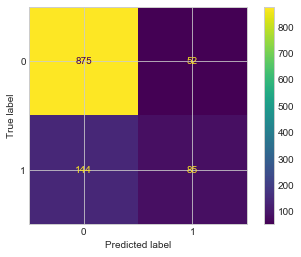

NT


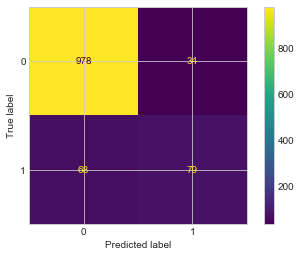

QL


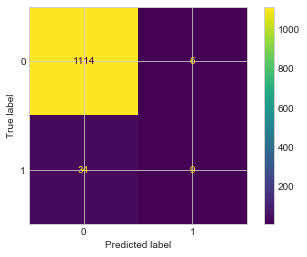

SA


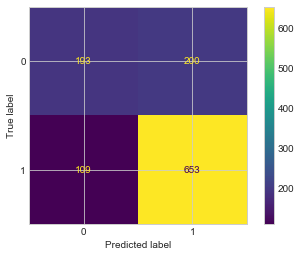

TA


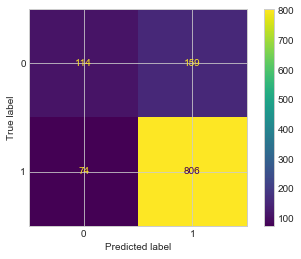

VI


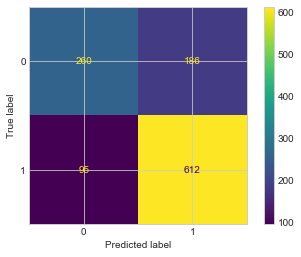

WA


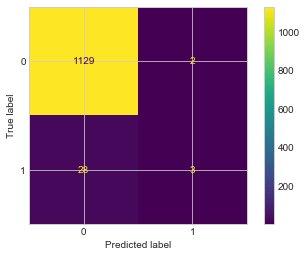

In [5]:
for region in regions:
    # read data
    df = pd.read_csv(f'../data/safe/{region}.csv')
    
    # split train / valid / test
    X, y = df.drop(['Date', 'Safe'], axis = 1), df['Safe']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    print(region)
    plot_confusion_matrix(clf[region], X_test, y_test)
    plt.show()

# RandomForest

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']
clf = {}
scores = {}

for region in regions:
    # read data
    df = pd.read_csv(f'../data/safe/{region}.csv')
    
    # split train / valid / test
    X, y = df.drop(['Date', 'Safe'], axis = 1), df['Safe']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

    # define objective function
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 600),
            'max_depth': trial.suggest_int('max_depth', 10, 20),
        }
        
        clf = RandomForestClassifier(**params)

        bst = clf.fit(X_train, y_train)
        pred_labels = bst.predict(X_valid)

        recall = recall_score(y_valid, pred_labels)
        return recall
                                                        
    # optuna optimize
    study = optuna.create_study(direction = "maximize")
    study.optimize(objective, n_trials=10)
    
    print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))
    
    # classifier
    best_params = study.best_trial.params
    clf[region] = RandomForestClassifier(**best_params)
    
    clf[region].fit(X_train, y_train)
    
    # predict
    score = {}
    
    y_pred = clf[region].predict(X_train)
    score['train'] = recall_score(y_train, y_pred)
    y_pred = clf[region].predict(X_valid)
    score['valid'] = recall_score(y_valid, y_pred)
    y_pred = clf[region].predict(X_test)
    score['test'] = recall_score(y_test, y_pred)
    
    scores[region] = score

[I 2021-01-13 19:48:14,037] A new study created in memory with name: no-name-f399d27b-9efa-4b54-a3a8-8679e6054fe5
[I 2021-01-13 19:48:19,701] Trial 0 finished with value: 0.36403508771929827 and parameters: {'n_estimators': 507, 'max_depth': 13}. Best is trial 0 with value: 0.36403508771929827.
[I 2021-01-13 19:48:25,468] Trial 1 finished with value: 0.37280701754385964 and parameters: {'n_estimators': 510, 'max_depth': 19}. Best is trial 1 with value: 0.37280701754385964.
[I 2021-01-13 19:48:30,933] Trial 2 finished with value: 0.3815789473684211 and parameters: {'n_estimators': 493, 'max_depth': 13}. Best is trial 2 with value: 0.3815789473684211.
[I 2021-01-13 19:48:35,561] Trial 3 finished with value: 0.35964912280701755 and parameters: {'n_estimators': 410, 'max_depth': 14}. Best is trial 2 with value: 0.3815789473684211.
[I 2021-01-13 19:48:41,279] Trial 4 finished with value: 0.35964912280701755 and parameters: {'n_estimators': 509, 'max_depth': 14}. Best is trial 2 with value: 

Best trial: score 0.3815789473684211, params {'n_estimators': 493, 'max_depth': 13}


[I 2021-01-13 19:49:15,325] A new study created in memory with name: no-name-558d9a3c-2bf4-4676-81c6-8016e7321172
[I 2021-01-13 19:49:20,583] Trial 0 finished with value: 0.5109489051094891 and parameters: {'n_estimators': 525, 'max_depth': 19}. Best is trial 0 with value: 0.5109489051094891.
[I 2021-01-13 19:49:25,110] Trial 1 finished with value: 0.5036496350364964 and parameters: {'n_estimators': 479, 'max_depth': 20}. Best is trial 0 with value: 0.5109489051094891.
[I 2021-01-13 19:49:30,370] Trial 2 finished with value: 0.48905109489051096 and parameters: {'n_estimators': 563, 'max_depth': 14}. Best is trial 0 with value: 0.5109489051094891.
[I 2021-01-13 19:49:38,082] Trial 3 finished with value: 0.5182481751824818 and parameters: {'n_estimators': 524, 'max_depth': 18}. Best is trial 3 with value: 0.5182481751824818.
[I 2021-01-13 19:49:45,644] Trial 4 finished with value: 0.5109489051094891 and parameters: {'n_estimators': 492, 'max_depth': 13}. Best is trial 3 with value: 0.518

Best trial: score 0.5182481751824818, params {'n_estimators': 524, 'max_depth': 18}


[I 2021-01-13 19:50:15,604] A new study created in memory with name: no-name-91bb558b-da6a-4af6-8913-3c0c43bc8130
[I 2021-01-13 19:50:21,126] Trial 0 finished with value: 0.13725490196078433 and parameters: {'n_estimators': 582, 'max_depth': 13}. Best is trial 0 with value: 0.13725490196078433.
[I 2021-01-13 19:50:26,159] Trial 1 finished with value: 0.11764705882352941 and parameters: {'n_estimators': 536, 'max_depth': 10}. Best is trial 0 with value: 0.13725490196078433.
[I 2021-01-13 19:50:30,173] Trial 2 finished with value: 0.11764705882352941 and parameters: {'n_estimators': 426, 'max_depth': 19}. Best is trial 0 with value: 0.13725490196078433.
[I 2021-01-13 19:50:34,055] Trial 3 finished with value: 0.09803921568627451 and parameters: {'n_estimators': 406, 'max_depth': 15}. Best is trial 0 with value: 0.13725490196078433.
[I 2021-01-13 19:50:38,657] Trial 4 finished with value: 0.13725490196078433 and parameters: {'n_estimators': 485, 'max_depth': 16}. Best is trial 0 with valu

Best trial: score 0.1568627450980392, params {'n_estimators': 543, 'max_depth': 19}


[I 2021-01-13 19:51:07,591] A new study created in memory with name: no-name-fe8cddb2-b3d9-4dba-aade-b022afc8058e
[I 2021-01-13 19:51:10,868] Trial 0 finished with value: 0.8672798948751642 and parameters: {'n_estimators': 403, 'max_depth': 12}. Best is trial 0 with value: 0.8672798948751642.
[I 2021-01-13 19:51:15,814] Trial 1 finished with value: 0.8607095926412615 and parameters: {'n_estimators': 577, 'max_depth': 19}. Best is trial 0 with value: 0.8672798948751642.
[I 2021-01-13 19:51:19,553] Trial 2 finished with value: 0.8791064388961892 and parameters: {'n_estimators': 525, 'max_depth': 10}. Best is trial 2 with value: 0.8791064388961892.
[I 2021-01-13 19:51:23,617] Trial 3 finished with value: 0.8580814717477004 and parameters: {'n_estimators': 471, 'max_depth': 19}. Best is trial 2 with value: 0.8791064388961892.
[I 2021-01-13 19:51:28,527] Trial 4 finished with value: 0.8607095926412615 and parameters: {'n_estimators': 548, 'max_depth': 20}. Best is trial 2 with value: 0.8791

Best trial: score 0.8791064388961892, params {'n_estimators': 525, 'max_depth': 10}


[I 2021-01-13 19:51:54,235] A new study created in memory with name: no-name-8b4740c5-fe52-456f-9383-5851d1b3d339
[I 2021-01-13 19:51:58,147] Trial 0 finished with value: 0.936562860438293 and parameters: {'n_estimators': 506, 'max_depth': 17}. Best is trial 0 with value: 0.936562860438293.
[I 2021-01-13 19:52:01,417] Trial 1 finished with value: 0.9296424452133795 and parameters: {'n_estimators': 436, 'max_depth': 16}. Best is trial 0 with value: 0.936562860438293.
[I 2021-01-13 19:52:05,370] Trial 2 finished with value: 0.9411764705882353 and parameters: {'n_estimators': 556, 'max_depth': 13}. Best is trial 2 with value: 0.9411764705882353.
[I 2021-01-13 19:52:09,990] Trial 3 finished with value: 0.9423298731257209 and parameters: {'n_estimators': 569, 'max_depth': 17}. Best is trial 3 with value: 0.9423298731257209.
[I 2021-01-13 19:52:13,962] Trial 4 finished with value: 0.9446366782006921 and parameters: {'n_estimators': 517, 'max_depth': 15}. Best is trial 4 with value: 0.9446366

Best trial: score 0.9469434832756632, params {'n_estimators': 513, 'max_depth': 10}


[I 2021-01-13 19:52:35,104] A new study created in memory with name: no-name-ee6722b6-6bb5-46dd-92e8-9df31b6940c4
[I 2021-01-13 19:52:39,409] Trial 0 finished with value: 0.8665749656121046 and parameters: {'n_estimators': 513, 'max_depth': 15}. Best is trial 0 with value: 0.8665749656121046.
[I 2021-01-13 19:52:43,904] Trial 1 finished with value: 0.8693259972489684 and parameters: {'n_estimators': 533, 'max_depth': 16}. Best is trial 1 with value: 0.8693259972489684.
[I 2021-01-13 19:52:47,461] Trial 2 finished with value: 0.8679504814305364 and parameters: {'n_estimators': 478, 'max_depth': 11}. Best is trial 1 with value: 0.8693259972489684.
[I 2021-01-13 19:52:51,880] Trial 3 finished with value: 0.8638239339752407 and parameters: {'n_estimators': 538, 'max_depth': 14}. Best is trial 1 with value: 0.8693259972489684.
[I 2021-01-13 19:52:55,624] Trial 4 finished with value: 0.8583218707015131 and parameters: {'n_estimators': 470, 'max_depth': 13}. Best is trial 1 with value: 0.8693

Best trial: score 0.8720770288858322, params {'n_estimators': 417, 'max_depth': 10}


[I 2021-01-13 19:53:21,842] A new study created in memory with name: no-name-ecbdc6d4-0323-4544-a182-23fe7663c479
[I 2021-01-13 19:53:27,322] Trial 0 finished with value: 0.030303030303030304 and parameters: {'n_estimators': 567, 'max_depth': 10}. Best is trial 0 with value: 0.030303030303030304.
[I 2021-01-13 19:53:31,891] Trial 1 finished with value: 0.06060606060606061 and parameters: {'n_estimators': 437, 'max_depth': 15}. Best is trial 1 with value: 0.06060606060606061.
[I 2021-01-13 19:53:36,954] Trial 2 finished with value: 0.030303030303030304 and parameters: {'n_estimators': 500, 'max_depth': 18}. Best is trial 1 with value: 0.06060606060606061.
[I 2021-01-13 19:53:41,360] Trial 3 finished with value: 0.030303030303030304 and parameters: {'n_estimators': 440, 'max_depth': 11}. Best is trial 1 with value: 0.06060606060606061.
[I 2021-01-13 19:53:46,164] Trial 4 finished with value: 0.030303030303030304 and parameters: {'n_estimators': 474, 'max_depth': 16}. Best is trial 1 with

Best trial: score 0.06060606060606061, params {'n_estimators': 437, 'max_depth': 15}


In [8]:
pd.DataFrame(scores)

,NSW,NT,QL,SA,TA,VI,WA
train,0.987106,1.000000,1.000000,0.994669,1.000000,0.991620,1.000000
valid,0.390351,0.489051,0.176471,0.875164,0.953864,0.874828,0.030303
test,0.327511,0.564626,0.046512,0.868766,0.950000,0.872702,0.064516


NSW


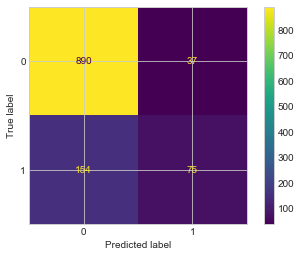

NT


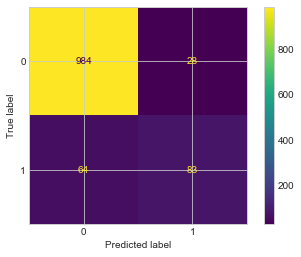

QL


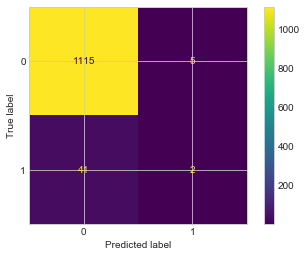

SA


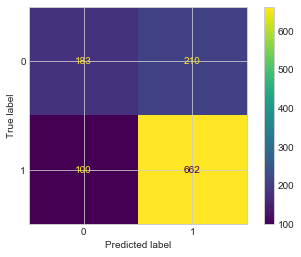

TA


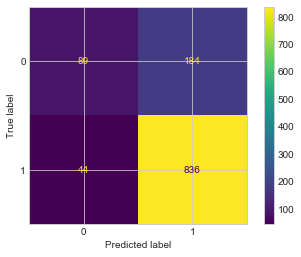

VI


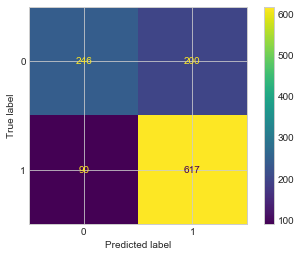

WA


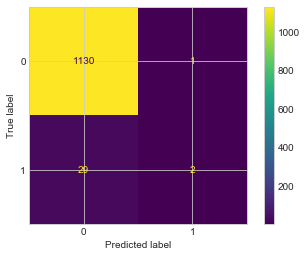

In [9]:
for region in regions:
    # read data
    df = pd.read_csv(f'../data/safe/{region}.csv')
    
    # split train / valid / test
    X, y = df.drop(['Date', 'Safe'], axis = 1), df['Safe']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    print(region)
    plot_confusion_matrix(clf[region], X_test, y_test)
    plt.show()

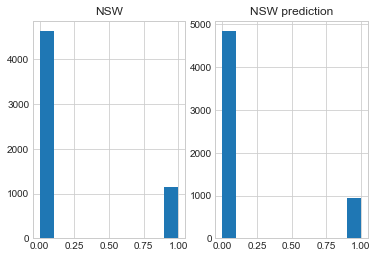

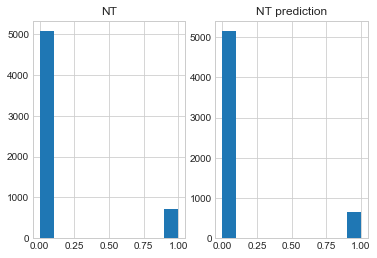

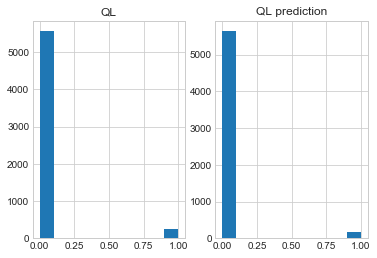

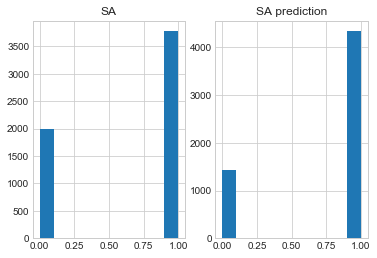

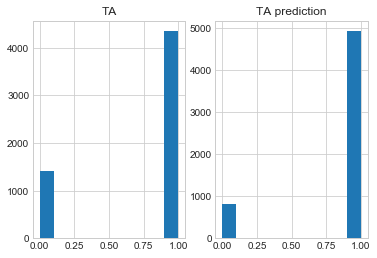

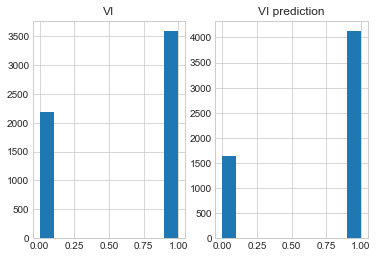

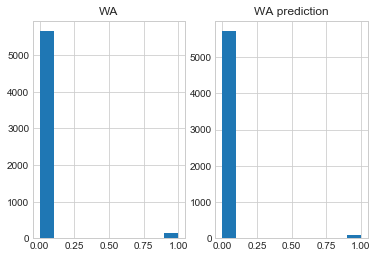

In [10]:
for region in regions:
    # read data
    df = pd.read_csv(f'../data/safe/{region}.csv')
    
    fig, axes = plt.subplots(1, 2)
    
    # show
    axes[0].set_title(region)
    axes[0].hist(df['Safe'])
    
    # show
    X = df.drop(['Date', 'Safe'], axis = 1)
    axes[1].set_title(f'{region} prediction')
    axes[1].hist(clf[region].predict(X))